# Read saved data

In [1]:
import os
from scipy.sparse import load_npz
import numpy as np
from datetime import datetime, timedelta
import time
import numpy as np
from numba import njit, prange

In [2]:
def get_dates():
    # Define the start and end dates
    start_date = datetime(2025, 1, 2)
    end_date = datetime(2025, 7, 1)

    # Generate a list of dates excluding weekends
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() < 5:  # Monday = 0, Sunday = 6
            date_list.append(current_date)
        current_date += timedelta(days=1)

    date_list = [date.strftime("%Y-%m-%d") for date in date_list]
    holidays = ["2025-04-18","2025-04-21", "2025-05-05", "2025-05-26"]
    for h in holidays:
        date_list.remove(h)

    print(len(date_list), "days between", date_list[0], date_list[-1])
    return date_list

In [3]:
def readc_day(day: str):
    folder = "CSR_Data"
    lob_data = load_npz(os.path.join(folder,"CSR_LOB_"+day+".npz")).toarray()
    lob_times = np.load(os.path.join(folder, "TIM_LOB_"+day+".npy"))
    tapes = np.load(os.path.join(folder, "TAP_"+day+".npy"))
    return lob_data, lob_times, tapes

def get_data(min_n = 0, max_n = 125):
    s = time.time()
    date_list = get_dates()
    all_data = []

    for day in date_list[min_n:max_n]:
        data = readc_day(day)
        all_data.append(data)

    print("Time taken to reach each day:", (time.time() - s) / (max_n - min_n))

    return all_data

data = get_data(0,125)
len(data)

125 days between 2025-01-02 2025-07-01
Time taken to reach each day: 0.19485191535949706


125

# Generate Features

In [4]:
@njit(parallel=True)
def get_features(lob_data: np.array, 
                 lob_times: np.array, 
                 tapes: np.array, 
                 time_step_s: int, 
                 ab_weight = 1, 
                 median = False, 
                 cas_cbs_window = 800):
    """
    Calculate features from LOB and Tapes data.

    Parameters:
    -----------
    lob_data : np.array
        Array containing the limit order book (LOB) data.
    lob_times : np.array
        Array containing timestamps for the LOB data.
    tapes : np.array
        Array containing Tapes data.
    time_step_s : int
        Time step in seconds for calculating features.
    ab_weight : float, optional
        Weight parameter for alpha and beta calculations, by default 1.
    median : bool, optional
        Whether to calculate features using median instead of mean, by default False.
    cas_cbs_window : int, optional
        Size of the window for calculating CAS and CBS, by default 800.

    Returns:
    --------
    tuple
        A tuple containing:
        - feat_arr: np.array
            Array containing feature values.
        - time_arr: np.array
            Array containing timestamps.
        - features: list
            List of feature names.
    """
    
    n_rows = int((8.5 * 60 * 60) / time_step_s)                         # define number of rows of output array
    features = ["MP","HIBID","LOASK","AP","WBP","WAP",                  # define features
                "TCBS","TCAS","AWS","VOL","GAP","SPREAD",
                "ALPHA", "BETA", "ZETA", "ENDT"]
    n_features = len(features)                                          # define number of features

    feat_arr = np.zeros((n_rows, n_features), dtype=np.float64)         # array to hold feature values
    
    LA_HB_a_b = np.zeros((lob_data.shape[0]+1, 4), dtype = np.float64)  # array holding the LOASK, HIBID,
                                                                        # alpha, beta, values 

    for i in prange(lob_data.shape[0]):                                 # iterates over the LOB to fill
        row = lob_data[i]                                               # LA_HB_a_b values
        
        neg_ind = np.where(row < 0)[0]                                  # locate bid and ask prices (indicies)
        pos_ind = np.where(row > 0)[0]
        
        if len(neg_ind) == 0:                                           # assign HIBID, np.nan if no values
            LA_HB_a_b[i][1] = np.nan
        else:
            LA_HB_a_b[i][1] = max(neg_ind) + 1 

        if len(pos_ind) == 0:                                           # assign HIBID, np.nan if no values
            LA_HB_a_b[i][0] = np.nan
        else:
            LA_HB_a_b[i][0] = min(pos_ind) + 1

        mid_price = (LA_HB_a_b[i][0] + LA_HB_a_b[i][1]) / 2             # calculate mid_price for alpha/beta calculations

        if np.isnan(mid_price):
            alpha = np.nan
            beta = np.nan
        else:                                                           # calculate alpha/beta using ab_weight var
            beta = 0
            for ind in neg_ind:
                beta += (-1 * row[ind]) / ((mid_price - (ind + 1)) + ab_weight)
    
            alpha = 0
            for ind in pos_ind:
                alpha += row[ind] / (((ind + 1) - mid_price) + ab_weight)
                

        LA_HB_a_b[i][2] = alpha
        LA_HB_a_b[i][3] = beta
        
    max_lob = lob_data.shape[0] - 1                                      # define max indicies for lob
    max_tapes = tapes.shape[0] - 1                                       # define max indicies for tapes
    
    start_time = 0                                                       # define start time
    lob_start = 0                                                        # define start index for lob
    tapes_start = 0                                                      # define start index for tapes
    
    cas = np.zeros(800, dtype = np.int16)                                # define an array to hold CAS values
    cbs = np.zeros(800, dtype = np.int16)                                # define an array to hold CBS values
    for row_i in range(n_rows):
        end_time = start_time + time_step_s                              # move to next time step
        lob_end = lob_start
        tapes_end = tapes_start

        # get lob slice
        while lob_times[lob_end] < end_time and lob_end < max_lob:       # move lob indicies to end time
            lob_end += 1
        
        # get tapes slice
        while tapes[tapes_end][0] < end_time and tapes_end < max_tapes:  # move tapes indicies to end time
            tapes_end += 1

        # feature calculations
        if tapes_start == tapes_end:                                     # if there is no tapes data
            AP = np.nan                                                  # set tapes features to np.nan
            VOL = np.nan
        else:
            tapes_slice = tapes[tapes_start:tapes_end]                   # extract tapes slice, calculate AP, VOL
            AP = 0
            for row in tapes_slice:
                AP += row[1] * row[2]
            VOL = np.sum(tapes_slice[:,2])
            AP = AP / VOL

        if lob_start == lob_end:                                         # if there is no LOB data
            MP = np.nan                                                  # set lob features to np.nan
            HIBID = np.nan
            LOASK = np.nan
            SPREAD = np.nan
            TCBS = np.nan
            TCAS = np.nan
            WBP = np.nan
            WAP = np.nan
            AWS = np.nan
            ALPHA = np.nan
            BETA = np.nan
            ZETA = np.nan  
        else:
            lob_slice = lob_data[lob_start:lob_end]                       # extract slices of data 
            LA_HB_a_b_slice = LA_HB_a_b[lob_start:lob_end]                

            # midprice_calcs, alpha, beta
            if median:                                                    # calculate price features
                HIBID = np.median(LA_HB_a_b_slice[:,1])                   # using median if set to true
                LOASK = np.median(LA_HB_a_b_slice[:,0])
                ALPHA = np.median(LA_HB_a_b_slice[:,2])
                BETA = np.median(LA_HB_a_b_slice[:,3])
            else:
                HIBID = np.nanmean(LA_HB_a_b_slice[:,1])
                LOASK = np.nanmean(LA_HB_a_b_slice[:,0])
                ALPHA = np.nanmean(LA_HB_a_b_slice[:,2])
                BETA = np.nanmean(LA_HB_a_b_slice[:,3])

            MP = (HIBID + LOASK) / 2
            SPREAD = LOASK - HIBID
            ZETA = BETA - ALPHA

            if HIBID >= LOASK:
                print("WARNING: HIBID >= LOASK")

            # consolidated calcs
            cas[:] = 0                                                      # reset cas, cbs arrays for new data
            cbs[:] = 0 
            idx_MP = int(MP - 1)                                            # calculate index for mid_price
            for ci in prange(800):
                # can optimise with LOASK AND HIBID here
                p = ci + 1

                if p <= LOASK + 100 and p >= idx_MP - cas_cbs_window:       # only calculate cbs between window left of MP
                    cbs_vec = lob_slice[:,ci].copy() * -1                   # and less than LOASK + 100 for efficiency
                    cbs_vec[cbs_vec <= 0] = 0                               # idk if this breaks things for efficiency ?:
                    cbs[ci] = np.sum(np.abs(np.diff(cbs_vec))) + cbs_vec[0]

                if p >= HIBID - 100 and p <= idx_MP + cas_cbs_window:       # only calculate cas between window right of MP
                    cas_vec = lob_slice[:,ci].copy()                        # and greater than HIBID - 100 for efficiency
                    cas_vec[cas_vec <= 0] = 0                               # idk if this breaks things for efficiency ?:
                    cas[ci] = np.sum(np.abs(np.diff(cas_vec))) + cas_vec[0]

            TCBS = np.sum(cbs)                                              # Total CBS
            TCAS = np.sum(cas)                                              # Total CAS

            if TCBS == 0:                                                   # Calculate WBP, np.nan if no activity
                WBP = np.nan
            else:
                WBP = 0
                for ci in prange(800):
                    WBP += (ci + 1) * (cbs[ci] / TCBS)

            if TCAS == 0:                                                   # Calculate WAP, np.nan if no activity
                WAP = np.nan
            else:
                WAP = 0
                for ci in prange(800):
                    WAP += (ci + 1) * (cas[ci] / TCAS)

            AWS = WAP - WBP                                                 # Activity weighted spread calc

        # feature setting
        feat_arr[row_i][features.index("AP")] = AP                          # set the values to the feat_arr
        feat_arr[row_i][features.index("VOL")] = VOL
        feat_arr[row_i][features.index("MP")] = MP
        feat_arr[row_i][features.index("HIBID")] = HIBID
        feat_arr[row_i][features.index("LOASK")] = LOASK
        feat_arr[row_i][features.index("SPREAD")] = SPREAD
        feat_arr[row_i][features.index("TCAS")] = TCAS
        feat_arr[row_i][features.index("TCBS")] = TCBS
        feat_arr[row_i][features.index("WAP")] = WAP
        feat_arr[row_i][features.index("WBP")] = WBP
        feat_arr[row_i][features.index("AWS")] = AWS
        feat_arr[row_i][features.index("ALPHA")] = ALPHA
        feat_arr[row_i][features.index("BETA")] = BETA
        feat_arr[row_i][features.index("ZETA")] = ZETA
        feat_arr[row_i][features.index("GAP")] = MP - AP
        feat_arr[row_i][features.index("ENDT")] = end_time


        # adjust start times
        start_time = end_time                                                # Set the next start times and 
        lob_start = lob_end                                                  # indicies to the last end times / indicies
        tapes_start = tapes_end

    return feat_arr, features

feat_arr = get_features(data[0][0],data[0][1],data[0][2], 60, cas_cbs_window = 50, median = True)
s = time.time()
feat_arr, feats = get_features(data[1][0],data[1][1],data[1][2], 60, cas_cbs_window = 50, median = True)
print(time.time() - s)
feat_arr

0.3539769649505615


array([[2.81000000e+02, 2.77000000e+02, 2.85000000e+02, ...,
        1.75232240e+00, 3.72372749e-01, 6.00000000e+01],
       [2.85500000e+02, 2.84000000e+02, 2.87000000e+02, ...,
        2.63499419e+00, 8.57038551e-01, 1.20000000e+02],
       [2.94000000e+02, 2.91000000e+02, 2.97000000e+02, ...,
        3.22343805e+00, 1.51616026e+00, 1.80000000e+02],
       ...,
       [2.99500000e+02, 2.96000000e+02, 3.03000000e+02, ...,
        3.10975282e+00, 2.23199982e+00, 3.04800000e+04],
       [2.96500000e+02, 2.92000000e+02, 3.01000000e+02, ...,
        9.50784506e-01, 7.91953523e-04, 3.05400000e+04],
       [3.01250000e+02, 2.91000000e+02, 3.11500000e+02, ...,
        1.11516810e+00, 6.91128696e-01, 3.06000000e+04]])

# Convert to DF

125 days between 2025-01-02 2025-07-01


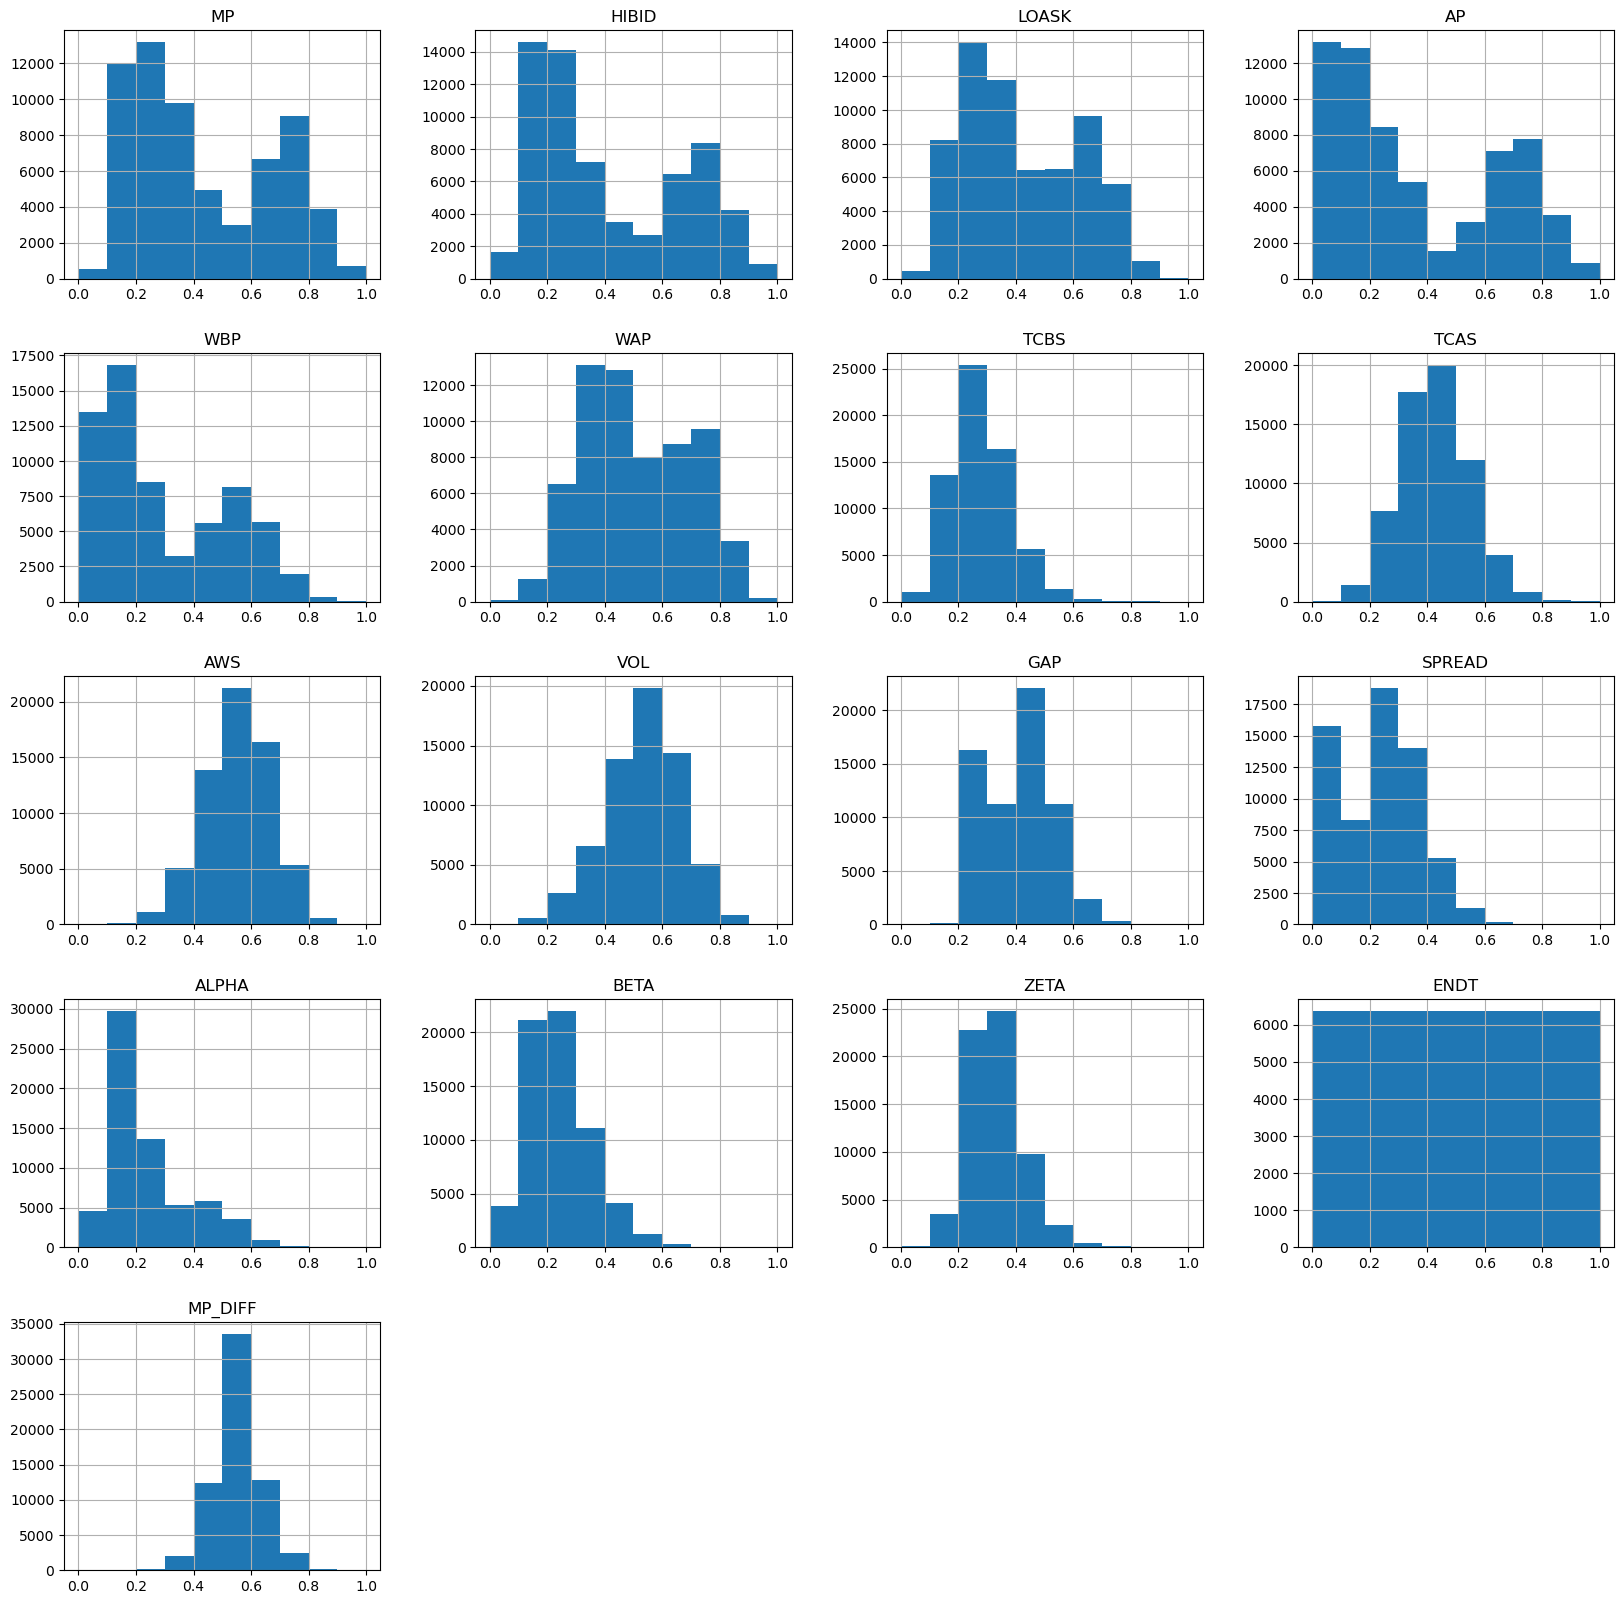

,MP,HIBID,LOASK,AP,WBP,WAP,TCBS,TCAS,AWS,VOL,GAP,SPREAD,ALPHA,BETA,ZETA,ENDT,MP_DIFF
date,,,,,,,,,,,,,,,,,
2025-01-02,0.564658,0.584992,0.495613,0.556265,0.480085,0.471984,0.237003,0.526900,0.290477,0.183486,0.269184,0.055571,0.616586,0.351879,0.280885,0.000000,NaN
2025-01-02,0.547397,0.580021,0.468791,0.551617,0.429162,0.549818,0.483327,0.347566,0.452015,0.541284,0.234573,0.013776,0.520779,0.314547,0.283022,0.001965,0.518225
2025-01-02,0.562865,0.594867,0.483016,0.562998,0.424247,0.655942,0.466834,0.391973,0.597968,0.385321,0.247085,0.014174,0.423835,0.459784,0.471851,0.003929,0.582677
2025-01-02,0.561713,0.594307,0.481442,0.559580,0.565642,0.589118,0.214055,0.554227,0.346799,0.357798,0.252743,0.012201,0.626844,0.467802,0.394818,0.005894,0.549949
2025-01-02,0.564343,0.595333,0.485276,0.559931,0.464864,0.568960,0.321800,0.535013,0.436206,0.284404,0.258935,0.017613,0.553320,0.390433,0.346764,0.007859,0.557398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-01,0.136899,0.102040,0.170566,0.025471,0.049169,0.319804,0.168698,0.511956,0.585538,0.559633,0.477240,0.302716,0.162640,0.198344,0.314824,0.992141,0.479213
2025-07-01,0.130585,0.105336,0.155927,0.026484,0.052630,0.191058,0.331302,0.385568,0.411354,0.596330,0.457624,0.269190,0.132538,0.263990,0.394415,0.994106,0.539783
2025-07-01,0.159976,0.103798,0.211039,0.030529,0.043121,0.354897,0.153281,0.443638,0.638896,0.467890,0.526478,0.376019,0.132436,0.242860,0.372906,0.996071,0.610097


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Assuming feat_arr is your data and feats is a list of column names
df = pd.DataFrame()
day_i = 0
date_list = get_dates()
for lob, lob_time, tapes, in data:
    feat_arr, f = get_features(lob, lob_time, tapes, 60)
    day_df = pd.DataFrame(feat_arr, columns=f)
    day_df["date"] = date_list[day_i]
    df = pd.concat([df, day_df], axis = 0)
    day_i += 1

df["MP_DIFF"] = df["MP"].diff()

df_index = df["date"]
df.drop(columns=["date"], inplace=True)

scaler = StandardScaler()
scaler.fit(df)
arr = scaler.transform(df)
scaler = MinMaxScaler()
scaler.fit(arr)
arr = scaler.transform(arr)
df = pd.DataFrame(arr, columns=df.columns)

df.index = pd.to_datetime(df_index)

df.hist(figsize = (20,20))
plt.show()
df

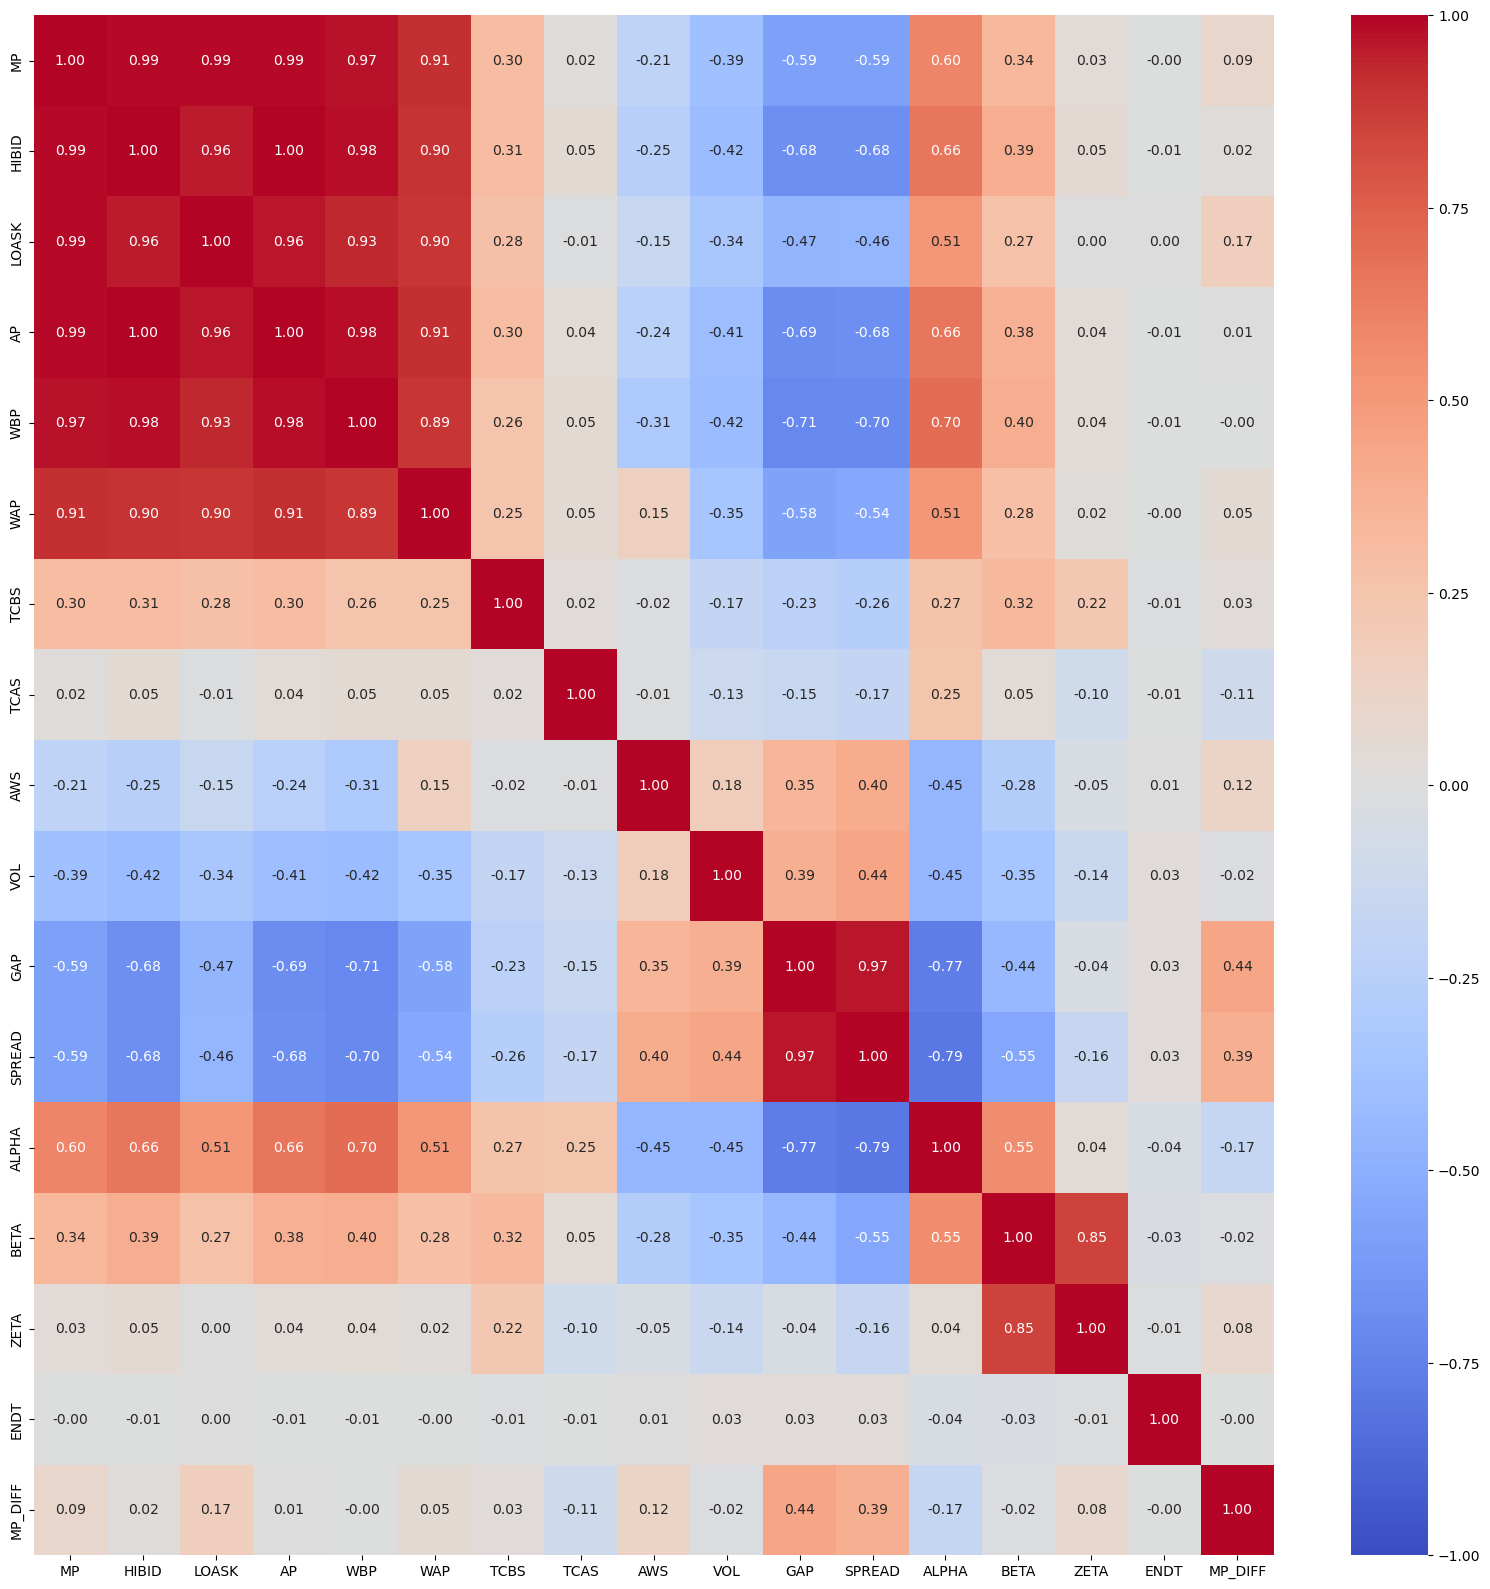

In [6]:
import seaborn as sns

plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin = -1, vmax = 1)
plt.show()

0.026000000000000002


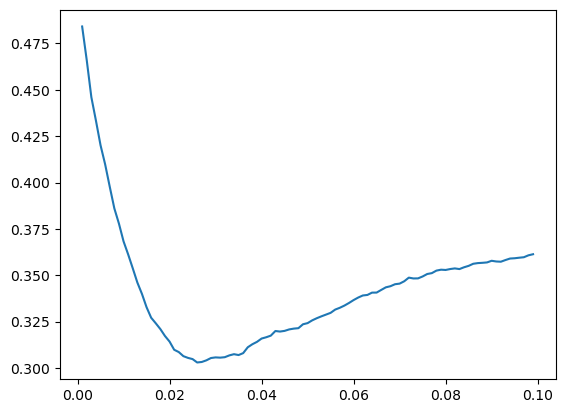

In [28]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

df = df.fillna(0)

# Define shown_features, y_feat, and y_func
shown_features = list(df)
y_feat = "MP_DIFF"
shown_features.remove(y_feat)
mean_y = np.mean(df[y_feat])

def y_func(x, eps = 0.5):
    if abs(x - mean_y) < eps:
        return 0
    elif x > mean_y:
        return 1
    else:
        return -1

# Prepare X and y
X = df[shown_features].to_numpy()

eps_x = np.arange(0.001,0.1,0.001)
var = []
for eps in eps_x:
    func = lambda x : y_func(x, eps)
    y = df[y_feat].apply(func)

    # Perform LDA
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_lda = lda.fit_transform(X, y)

    # Print explained variance ratio and coefficients
    var.append(abs(lda.explained_variance_ratio_[0] - 0.5))
print(eps_x[np.argmin(var)])
plt.plot(eps_x, var)

In [29]:
func = lambda x : y_func(x, eps_x[np.argmin(var)])
y = df[y_feat].apply(func)

# Perform LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

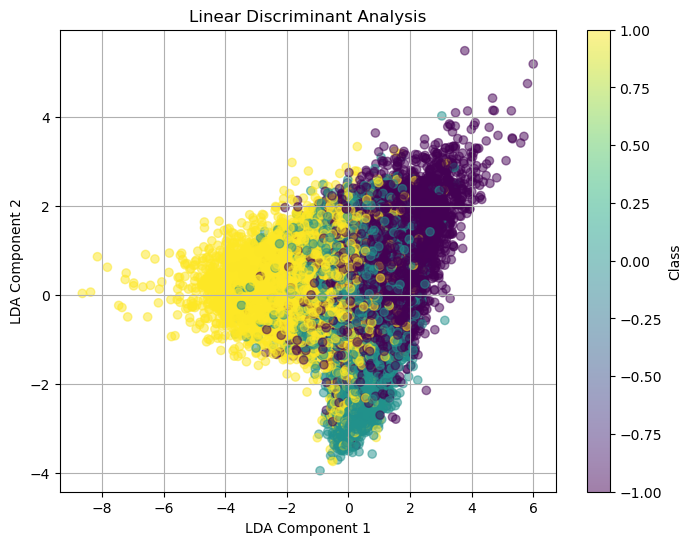

In [30]:
import matplotlib.pyplot as plt

# Plot the LDA-transformed features
plt.figure(figsize=(8, 6))
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title('Linear Discriminant Analysis')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

In [31]:
pp_df = pd.concat([pd.DataFrame(X, columns=shown_features), pd.DataFrame(y.to_numpy(), columns=["Labels"])], axis = 1)
print(pp_df["Labels"].value_counts())
pp_df

-1    22027
 1    21310
 0    20413
Name: Labels, dtype: int64


,MP,HIBID,LOASK,AP,WBP,WAP,TCBS,TCAS,AWS,VOL,GAP,SPREAD,ALPHA,BETA,ZETA,ENDT,Labels
0,0.564658,0.584992,0.495613,0.556265,0.480085,0.471984,0.237003,0.526900,0.290477,0.183486,0.269184,0.055571,0.616586,0.351879,0.280885,0.000000,-1
1,0.547397,0.580021,0.468791,0.551617,0.429162,0.549818,0.483327,0.347566,0.452015,0.541284,0.234573,0.013776,0.520779,0.314547,0.283022,0.001965,-1
2,0.562865,0.594867,0.483016,0.562998,0.424247,0.655942,0.466834,0.391973,0.597968,0.385321,0.247085,0.014174,0.423835,0.459784,0.471851,0.003929,1
3,0.561713,0.594307,0.481442,0.559580,0.565642,0.589118,0.214055,0.554227,0.346799,0.357798,0.252743,0.012201,0.626844,0.467802,0.394818,0.005894,0
4,0.564343,0.595333,0.485276,0.559931,0.464864,0.568960,0.321800,0.535013,0.436206,0.284404,0.258935,0.017613,0.553320,0.390433,0.346764,0.007859,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63745,0.136899,0.102040,0.170566,0.025471,0.049169,0.319804,0.168698,0.511956,0.585538,0.559633,0.477240,0.302716,0.162640,0.198344,0.314824,0.992141,-1
63746,0.130585,0.105336,0.155927,0.026484,0.052630,0.191058,0.331302,0.385568,0.411354,0.596330,0.457624,0.269190,0.132538,0.263990,0.394415,0.994106,0
63747,0.159976,0.103798,0.211039,0.030529,0.043121,0.354897,0.153281,0.443638,0.638896,0.467890,0.526478,0.376019,0.132436,0.242860,0.372906,0.996071,1
63748,0.137648,0.104275,0.169822,0.032567,0.053020,0.338856,0.341879,0.343723,0.606291,0.486239,0.461064,0.297326,0.156415,0.333406,0.455196,0.998035,-1


Finished fold 1
Finished fold 2
Finished fold 3
Finished fold 4
Finished fold 5
Finished fold 6


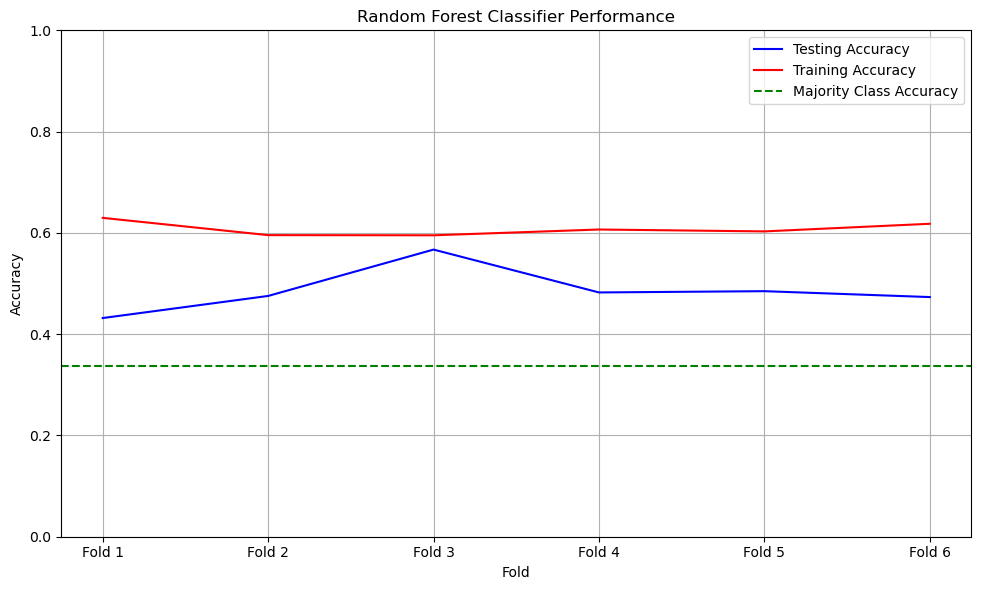

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

train_acc = []
test_acc = []

df_index = pd.to_datetime(df_index)

for i in range(6): # 6 folds
    if i == 5:
        train_ind = (df_index.dt.month >= 6).to_numpy()
    else:
        train_ind = (df_index.dt.month == (i+1)).to_numpy()

    x_feats = list(pp_df)
    # x_feats = ["GAP","ALPHA","BETA","AWS","SPREAD","VOL","ZETA","TCBS","TCAS","Labels"] # non-price related features
    y_feat = "Labels"
    x_feats.remove(y_feat)

    X_train = pp_df[train_ind][x_feats].to_numpy()
    y_train = pp_df[train_ind][y_feat].to_numpy()

    X_test = pp_df[~train_ind][x_feats].to_numpy()
    y_test = pp_df[~train_ind][y_feat].to_numpy()

    clf = RandomForestClassifier(max_depth=3,n_estimators=200)

    clf.fit(X_train, y_train)

    train_acc.append(accuracy_score(clf.predict(X_train), y_train))
    test_acc.append(accuracy_score(clf.predict(X_test), y_test))

    print("Finished fold", i+1)

majority_class_acc = max(sum(y_test == 1) / len(y_test), sum(y_test == 0) / len(y_test), sum(y_test == -1) / len(y_test))

# Plotting
plt.figure(figsize=(10, 6))


plt.plot(test_acc, 'b', label='Testing Accuracy')
plt.plot(train_acc, 'r', label='Training Accuracy')
plt.axhline(y=majority_class_acc, color='g', linestyle='--', label='Majority Class Accuracy')

plt.title('Random Forest Classifier Performance')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(6), ['Fold {}'.format(i+1) for i in range(6)])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0,1)
plt.show()


In [44]:
clf = RandomForestClassifier(max_depth=3,n_estimators=200)
clf.fit(pp_df[train_ind][x_feats], pp_df[train_ind][y_feat])

feat_list = list(zip(x_feats, clf.feature_importances_))
feat_list.sort(key = lambda x : x[1], reverse=True)
for f, imp in feat_list:
    print(f, "\t", imp)

GAP 	 0.5275302340040048
SPREAD 	 0.38453122634378906
ALPHA 	 0.05950460325424911
AWS 	 0.011013455613510007
ZETA 	 0.00736968631816356
TCAS 	 0.004255884018125214
BETA 	 0.003265249206150694
VOL 	 0.0020200254429023007
TCBS 	 0.0005096357991052703


# do not run

# writing time index for LOB

from numba import njit, prange
import os
from tools import read_csr, get_Tapes


#@njit(parallel=True)
def get_times_s(raw_lob: list[str]):
    n = len(raw_lob)
    times = np.zeros(n)

    for i in range(n):
        times[i] = float(raw_lob[i].split(",")[0][1:])
    
    return times


def run_box():
    LOB_filename = os.listdir("Data\LOBs")
    for filename in LOB_filename:
        with open(f"Data\LOBs\{filename}", 'r') as f:
            raw_lob = f.readlines()

        times = get_times_s(raw_lob)
        save_name = f"CSR_Data\TIM_LOB_{filename.split('L')[0].split('_')[2]}.npy"
        print(save_name)
        np.save(save_name, times)

# run_box()

# writing tapes data

import pandas as pd

def run_box():
    Tapes_filenames = os.listdir("Data\Tapes")
    for filename in Tapes_filenames:
        tapes = pd.read_csv(f"Data\Tapes\{filename}")
        np_tapes = tapes.to_numpy()
        print(filename)
        np.save(f"CSR_Data\TAP_{filename.split('ta')[0].split('_')[2]}.npy", np_tapes)

#run_box()